In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import PPO
from PIL import Image, ImageDraw
import json
from stable_baselines3.common.env_checker import check_env
import gymnasium as gym
from rl_environment import SegmentationEnv

/home/jaspe/mambaforge/envs/maps/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


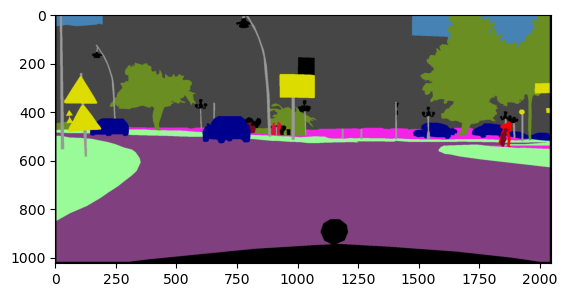

In [2]:
# Get image
PATH = '../data/gtFine/train/aachen/aachen_000000_000019_gtFine_color.png'
image = Image.open(PATH)

# Display image
plt.imshow(image)
plt.show()

In [3]:
# Load the polygon label data
LABEL_PATH = '../data/gtFine/train/aachen/aachen_000000_000019_gtFine_polygons.json'
with open(LABEL_PATH) as f:
    polygons = json.load(f)
    
polygons 

{'imgHeight': 1024,
 'imgWidth': 2048,
 'objects': [{'label': 'road',
   'polygon': [[0, 769],
    [290, 574],
    [93, 528],
    [0, 524],
    [0, 448],
    [0, 448],
    [210, 453],
    [511, 451],
    [782, 459],
    [892, 495],
    [943, 498],
    [1044, 471],
    [1490, 486],
    [1880, 519],
    [1922, 512],
    [1975, 522],
    [2047, 524],
    [2047, 570],
    [1668, 553],
    [2047, 597],
    [2047, 1023],
    [892, 1023],
    [0, 1023]]},
  {'label': 'sidewalk',
   'polygon': [[2047, 532],
    [1911, 537],
    [1828, 540],
    [1782, 540],
    [1794, 552],
    [2047, 564]]},
  {'label': 'car',
   'polygon': [[806, 503],
    [803, 524],
    [796, 528],
    [785, 528],
    [778, 527],
    [776, 520],
    [771, 520],
    [768, 515],
    [732, 515],
    [728, 523],
    [722, 523],
    [715, 524],
    [714, 523],
    [711, 520],
    [709, 517],
    [706, 517],
    [702, 520],
    [697, 529],
    [690, 532],
    [681, 532],
    [678, 529],
    [674, 527],
    [671, 517],
    [635, 

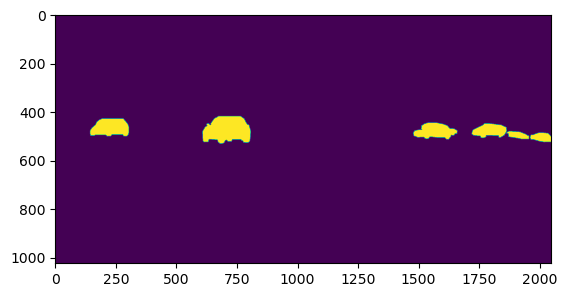

In [4]:
# Create a mask image
mask = Image.new('L', (polygons['imgWidth'], polygons['imgHeight']), 0)
draw = ImageDraw.Draw(mask)

# Draw the polygons for the current label
for obj in polygons['objects']:
    if obj['label'] == "car":

        polygon = obj['polygon']
        # Convert list of lists to list of tuples
        polygon_tuples = [tuple(point) for point in polygon]
        draw.polygon(polygon_tuples, outline=1, fill=1)
        
mask_array = np.array(mask)
plt.imshow(mask_array)
plt.show()

In [5]:
# Convert PNG image to numpy array
image_array = np.array(image)

# Grey scale the image
grey_image = image.convert('L')
grey_image_array = np.array(grey_image)

mask_array = np.array(mask)

In [6]:
# get uniquve values or labels in the mask
mask_array.shape

(1024, 2048)

Creating Environment...
Running Episode...


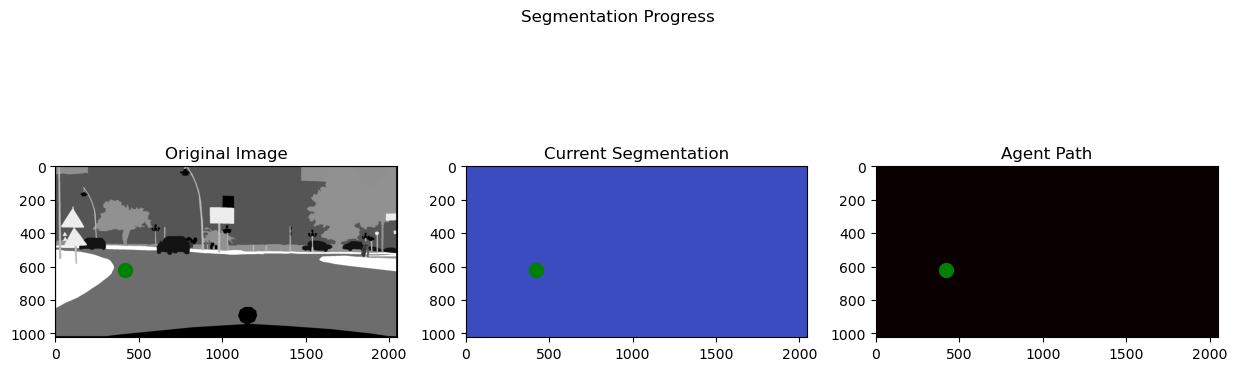

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode finished!
Total reward: -3.00
Coverage: 0.0%
Accuracy: 97.8%


In [14]:
# Create sample data
height, width = 100, 100

# Create environment
print("Creating Environment...")
env = SegmentationEnv(image=grey_image_array, labels=mask_array, step_limit=10)

# Run Episode
print("Running Episode...")
obs = env.reset()
total_reward = 0

while True:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    total_reward += reward

    env.render()

    if done:
        print(f"Episode finished!")
        print(f"Total reward: {total_reward:.2f}")
        print(f"Coverage: {info['coverage']*100:.1f}%")
        print(f"Accuracy: {info['accuracy']*100:.1f}%")
        break

plt.ioff()
plt.show()

In [7]:
possible_labels = ['road', 'sidewalk', 'parking', 'rail track', 'person', 'rider', 'car', 'truck', 'bus', 'on rails', 'motorcycle', 'bicycle', 'caravan', 'trailer', 'building', 'wall', 'fence', 'guard rail', 'bridge', 'tunnel', 'pole', 'pole group', 'traffic sign', 'traffic light', 'vegetation', 'terrain', 'sky', 'ground', 'dynamic', 'static']

height, width = polygons['imgHeight'], polygons['imgWidth']
num_labels = len(possible_labels)
combined_masks = np.zeros((height, width, num_labels), dtype=np.uint8)

for idx, label in enumerate(possible_labels):
    # Create a mask image
    mask = Image.new('L', (polygons['imgWidth'], polygons['imgHeight']), 0)
    draw = ImageDraw.Draw(mask)
    
    # Draw the polygons for the current label
    for obj in polygons['objects']:
        if obj['label'] == label:

            polygon = obj['polygon']
            # Convert list of lists to list of tuples
            polygon_tuples = [tuple(point) for point in polygon]
            draw.polygon(polygon_tuples, outline=1, fill=1)
            
    mask_array = np.array(mask)
    combined_masks[:, :, possible_labels.index(label)] = mask_array
    
# Save the combined masks array
np.save('output/combined_masks.npy', combined_masks)

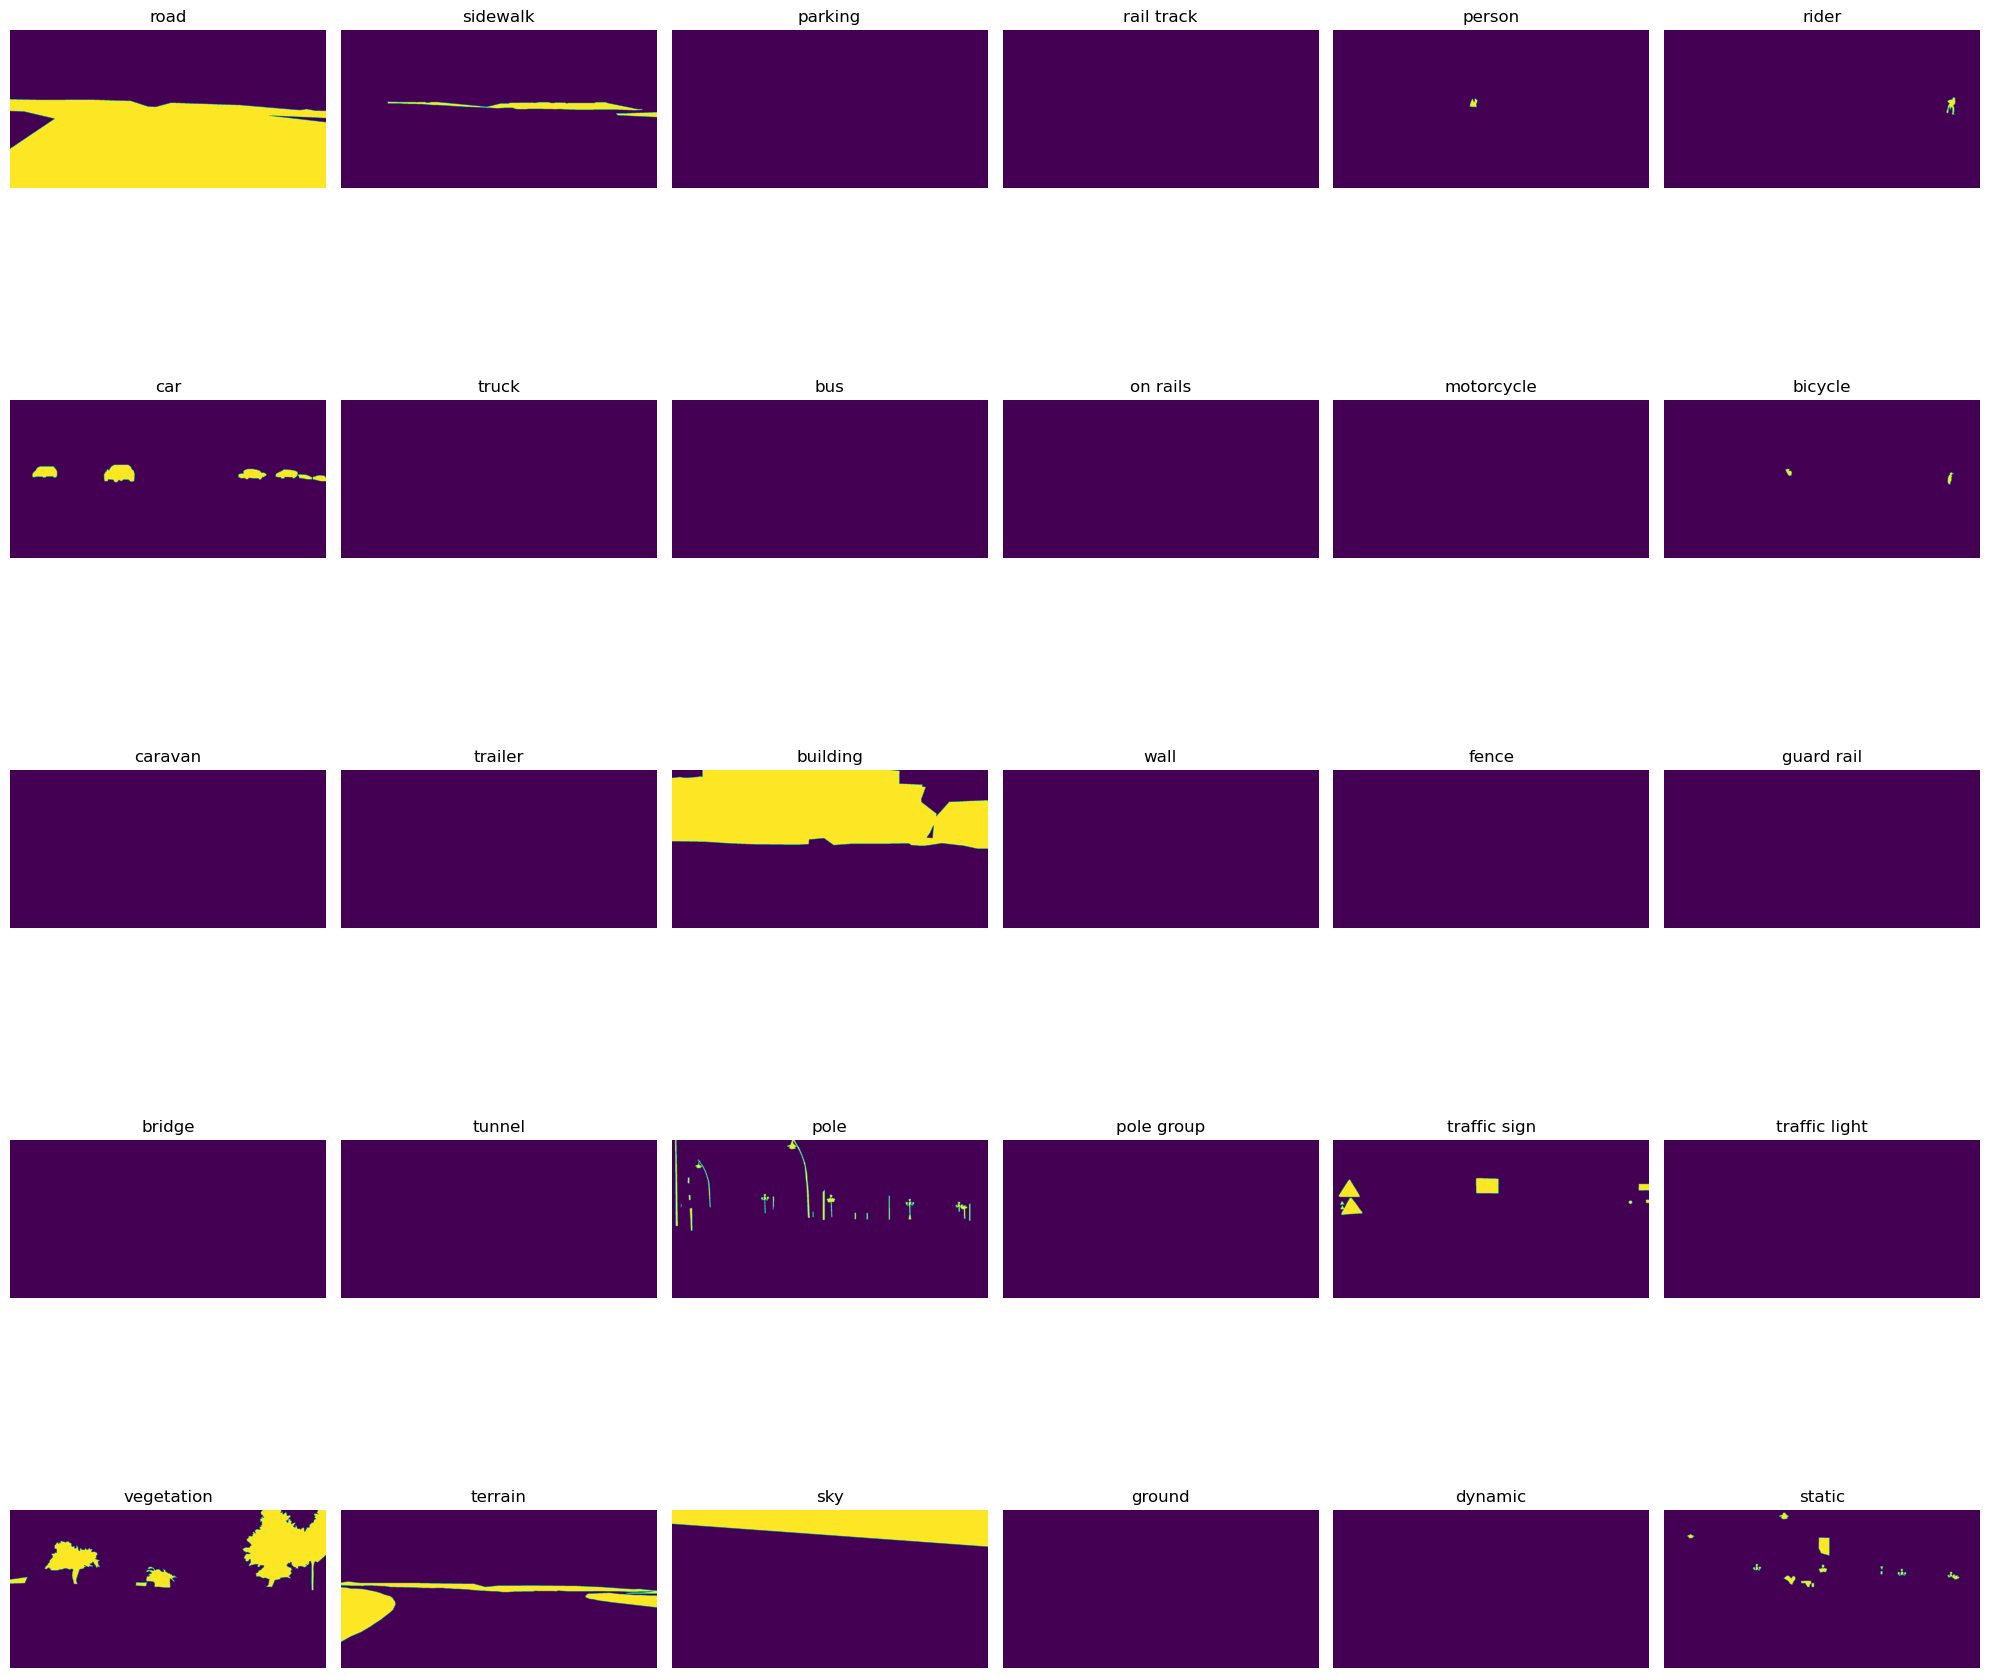

In [8]:
# Display images by label
fig, axes = plt.subplots(5, 6, figsize=(20, 20))

for idx, ax in enumerate(axes.flat):
    ax.imshow(combined_masks[:, :, idx])
    ax.set_title(possible_labels[idx])
    ax.axis('off')
    
plt.tight_layout()
plt.show()

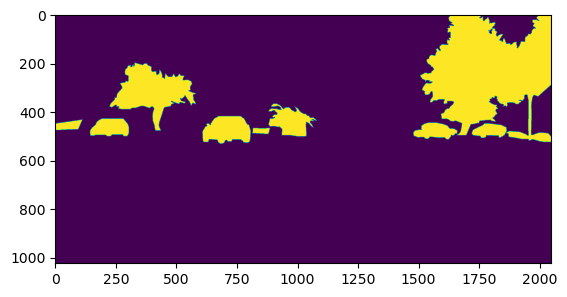

(1024, 2048)

In [ ]:
# Combine car and vegetation masks
car_mask = combined_masks[:, :, possible_labels.index('car')]
vegetation_mask = combined_masks[:, :, possible_labels.index('vegetation')]
combined_mask = np.logical_or(car_mask, vegetation_mask)

# Convert values to 1s and 0s
combined_mask = combined_mask.astype(np.uint8)

# Display the combined mask
plt.imshow(combined_mask)
plt.show()

# Save image as a npy
np.save('output/combined_mask.npy', combined_mask)

combined_mask.shape

In [13]:
int(combined_mask[0, 1])

0